In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import os
from collections import defaultdict 
from nltk.corpus import stopwords

In [2]:
data_path = '../data/'
sen_names = pd.read_csv(os.path.join(data_path, "raw/handles.csv"))
tweets = pd.read_csv(os.path.join(data_path, "tweets.csv"))
edges = pd.read_csv(os.path.join(data_path, "edges.csv"))

In [3]:
G = nx.DiGraph()

In [4]:
party_dict = dict(zip(sen_names["Name"], sen_names["Party"]))
for i in sen_names["Name"]:
    G.add_node(i, party = party_dict[i])
G.add_edges_from(list(zip(edges["followed"], edges["following"])))

In [5]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 3823
Average in degree:  38.2300
Average out degree:  38.2300


C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


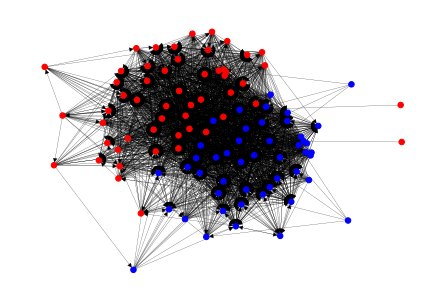

In [6]:
options = {
    'node_size': 30,
    'width': 0.2,
}
nx.draw_kamada_kawai(G, node_color = ['red' if i[1]['party'] == 'R' else 'blue' for i in G.nodes.data()], **options)

In [7]:
# Closeness centrality
cen_close = nx.closeness_centrality(G)
cen_close

{'AK Lisa Murkowski': 0.8048780487804879,
 'AK Dan Sullivan': 0.7279411764705882,
 'AL Doug Jones': 0.6827586206896552,
 'AL Richard C. Shelby': 0.7226277372262774,
 'AR John Boozman': 0.6111111111111112,
 'AR Tom Cotton': 0.6,
 'AZ Martha McSally': 0.0,
 'AZ Kyrsten Sinema': 0.853448275862069,
 'CA Dianne Feinstein': 0.7122302158273381,
 'CA Kamala D. Harris': 0.5051020408163265,
 'CO Michael F. Bennet': 0.7983870967741935,
 'CO Cory Gardner': 0.61875,
 'CT Richard Blumenthal': 0.6923076923076923,
 'CT Christopher Murphy': 0.0,
 'DE Thomas R. Carper': 0.8319327731092437,
 'DE Christopher A. Coons': 0.8114754098360656,
 'FL Marco Rubio': 0.6305732484076433,
 'FL Rick Scott': 0.9252336448598131,
 'GA Johnny Isakson': 0.0,
 'GA David Perdue': 0.22,
 'HI Mazie K. Hirono': 0.6875,
 'HI Brian Schatz': 0.5439560439560439,
 'IA Joni Ernst': 0.6556291390728477,
 'IA Chuck Grassley': 0.5469613259668509,
 'ID Mike Crapo': 0.46261682242990654,
 'ID James E. Risch': 0.46261682242990654,
 'IL Tammy

In [8]:
print("The highest closeness centrality:", max(cen_close.values()))
print("The most important senator (highest centrality): WA Maria Cantwell")

The highest closeness centrality: 0.9428571428571428
The most important senator (highest centrality): WA Maria Cantwell


In [9]:
ccdf = pd.DataFrame([cen_close.keys(), cen_close.values()]).transpose()
ccdf.columns = ["Name", "Centrality"]
ccdf["Party"] = ccdf["Name"].apply(lambda x: party_dict[x])
ccdf["Centrality"] = pd.to_numeric(ccdf["Centrality"])
ccdf.groupby("Party").mean()

,Centrality
Party,
D,0.535133
I,0.860870
R,0.520566


In [19]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
voting_data = pd.read_csv(os.path.join(data_path, "voting_data.csv"))
dec_dict = dict(zip(list(set(voting_data["Decision"])), list(range(len(voting_data["Decision"])))))
voting_data["Decision"] = voting_data["Decision"].apply(lambda x : dec_dict[x])
voting_piv = pd.pivot_table(voting_data, index='Senator Name', columns='Bill')
voting_piv.head()

Decision                             ...                 \
Bill                       0  1  2  3  4  5  6  7  8  9   ... 69 70 71 72 73   
Senator Name                                              ...                  
AK Dan Sullivan             0  0  0  0  2  2  2  2  0  0  ...  0  0  0  0  0   
AK Lisa Murkowski           0  0  0  0  2  2  0  2  0  0  ...  0  0  0  0  0   
AL Doug Jones               0  0  0  0  0  0  0  2  0  0  ...  0  0  2  2  2   
AL Richard C. Shelby        0  0  0  0  2  2  2  2  0  0  ...  0  0  0  0  0   
AR John Boozman             0  0  0  0  2  2  2  2  0  0  ...  0  0  0  0  0   

                                     
Bill                 74 75 76 77 78  
Senator Name                         
AK Dan Sullivan       0  0  0  0  0  
AK Lisa Murkowski     0  0  0  0  0  
AL Doug Jones         2  2  2  2  2  
AL Richard C. Shelby  0  0  0  0  0  
AR John Boozman       0  0  0  0  0  

[5 rows x 79 columns]

In [39]:
dec_dict_r = dict(zip(dec_dict.values(), dec_dict.keys()))
closeness = ccdf.set_index("Name")
for i in dec_dict_r.keys():
    temp = (voting_piv == i).sum(axis = 1)
    closeness[dec_dict_r[i]] = temp
closeness.corr()["Centrality"]

Centrality    1.000000
Yea          -0.024477
Present       0.017379
Nay          -0.033299
Not Voting    0.059425
Name: Centrality, dtype: float64

In [40]:
Not Voting

SyntaxError: invalid syntax (<ipython-input-40-8e42e615c293>, line 1)

In [12]:
new = tweets.groupby("Senator Name").agg({"Tweets": sum})

In [13]:
def pop_words(tweets):
    #generate top 1000 popular words
    tweets = tweets.groupby("Senator Name").agg({"Tweets": sum})
    total_words = defaultdict(int)
    stopWords = set(stopwords.words('english'))
    total_tweet = tweets["Tweets"].values
    for i in total_tweet:
        row_words = i.split()
        for j in row_words:
            j = j.lower()
            if j not in stopWords:
                total_words[j] += 1
    total_words = {key: val for key, val in sorted(total_words.items(), key = lambda ele: ele[1], reverse = True)}
    total_keys = total_words.keys()
    top_1000 = []
    count = 0
    for z in total_keys:
        top_1000.append(z)
        count += 1
        if count == 1000:
            break;
    id_1000 = dict(zip(top_1000, range(1000)))
    
    #create features
    feature = []
    for i in total_tweet:
        feat = [0]*1000
        row_words = i.split()
        for j in row_words:
            if j in top_1000:
                feat[id_1000[j]] += 1
        feature.append(feat)
    return feature

In [14]:
feature = pop_words(tweets)

KeyboardInterrupt: 

In [ ]:
dec_dict